# Compute functional connectivity with the corrcoef analyzer

This demo shows how to build a region time series object from simulated data and then apply a time series analyzer, corrcoef in this case, to the time series, resulting in functional connectivity.

First, we build the simulator

In [2]:
!pip install tvb-data
!pip install -U tvb-library

%pylab inline

from tvb.simulator.lab import *
from tvb.datatypes import graph
from tvb.datatypes.time_series import TimeSeriesRegion

# neural mass model parameters
pars = {'a': numpy.array([1.8])}

# sampling frequency
sfreq = 2048.0

conn=connectivity.Connectivity.from_file()
conn.speed=numpy.array([4.0])
sim = simulator.Simulator(
    model=models.Generic2dOscillator(**pars),
    connectivity=conn,
    coupling=coupling.Linear(a=numpy.array([0.033])),
    integrator=integrators.HeunStochastic(dt=0.06103515625, noise=noise.Additive(nsig=numpy.array([2 ** -10, ]))),
    monitors=(monitors.TemporalAverage(period=1e3 / sfreq),
              monitors.ProgressLogger(period=2e3)),
    simulation_length=16e3
).configure()

WARNING  File 'hemispheres' not found in ZIP.


and then run it

In [3]:
(tavg_time, tavg_samples), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 32769 time 2.0001 s
   INFO  step 65537 time 4.0001 s
   INFO  step 98305 time 6.0001 s
   INFO  step 131073 time 8.0001 s
   INFO  step 163841 time 10.0001 s
   INFO  step 196609 time 12.0001 s
   INFO  step 229377 time 14.0001 s


For the analyzer, we build a time series object,

In [4]:
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=tavg_samples,
                       sample_period=sim.monitors[0].period)
tsr.configure()

and create & evaluate the analysis

In [5]:
def ev(tsr):
    input_shape = tsr.data.shape
    result_shape = (input_shape[2], input_shape[2], input_shape[1], input_shape[3])
    result = numpy.zeros(result_shape)

    for mode in range(result_shape[3]):
        for var in range(result_shape[2]):
            data = tsr.data[:,var,:, mode].squeeze()
            result[:, :, var, mode] = numpy.corrcoef(data.T)

    corr_coeff = graph.CorrelationCoefficients(source=tsr, array_data=result)
    return corr_coeff

In [6]:
result = ev(tsr)

FC = result.array_data[..., 0, 0]

print(FC.shape)

(76, 76)


and display the resulting triangular matrix

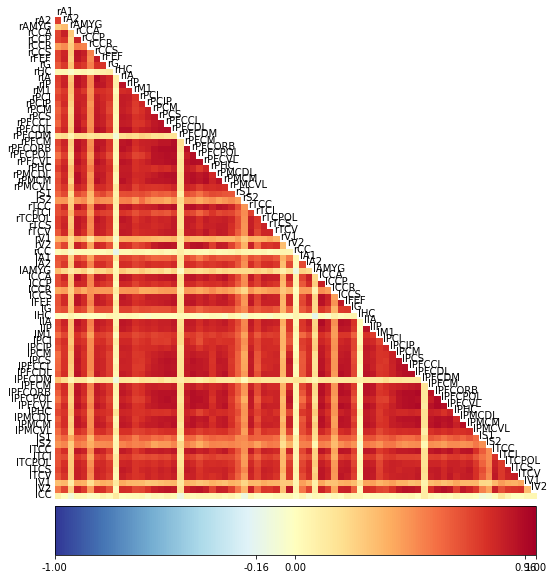

In [7]:
plot_tri_matrix(FC,
                cmap=pyplot.cm.RdYlBu_r, 
                node_labels= sim.connectivity.region_labels,
                size=[10., 10.],
                color_anchor=(-1.0, 1.0));